In [1]:
import numpy as np

In [2]:
import pymc4 as pm
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Forward Sampling

In [9]:
@pm.model
def mixture(n_groups, n_points):    
    centers = pm.Normal(mu=tf.zeros((n_groups, 2)), sigma=1, name='centers')
    scales = pm.HalfNormal(0.4 * tf.ones(n_groups), name='scales')
    rates = pm.Dirichlet(a=tf.ones(n_groups), name='rates')
    
    group_assignments = pm.Multinomial(n=n_points, p=rates, name='group_assignments')
    
    for idx in range(n_groups):
        count = group_assignments[idx]
        pm.Normal(mu=centers[idx] * tf.ones((count, 2)), sigma=scales[idx], name=f'group_{idx}')
    
    
model = mixture.configure(n_groups=5, n_points=10_000)

tf.Tensor([0.06926113 0.44744077 0.01934566 0.12619576 0.3377567 ], shape=(5,), dtype=float32)


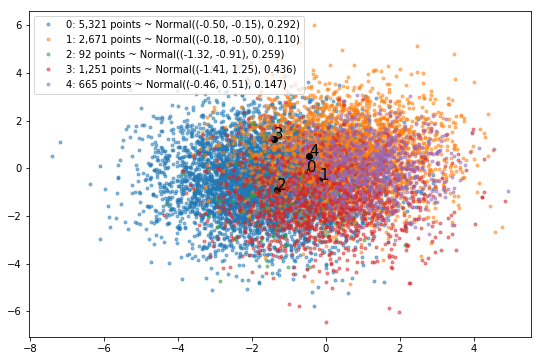

In [16]:
forward_sample = model.forward_sample()

centers = forward_sample['centers'].numpy()
scales = forward_sample['scales'].numpy()
group_assignments = forward_sample['group_assignments'].numpy()

fig, ax = plt.subplots(figsize=(9, 6))

for idx, (center, scale, count) in enumerate(zip(centers, scales, group_assignments)):
    group = forward_sample[f'group_{idx}']
    center_str = ', '.join(f'{c:.2f}' for c in center)
    label = f'{idx}: {int(count):,d} points ~ Normal(({center_str}), {scale:.3f})'
    ax.plot(group[:, 0], group[:, 1], '.', alpha=0.5, label=label)
    ax.plot(center[0], center[1], 'ko')
    ax.text(center[0], center[1], str(idx), size=15)

ax.legend();
print(forward_sample['rates'])

## Different ways to evaluate logp

In [17]:
@pm.model(auto_name=True)
def t_test(sd_prior='half_normal'):
    mu = pm.Normal(0, 1)
    sd = pm.HalfNormal(1)
    y_0 = pm.Normal(0, 2 * sd)
    y_1 = pm.Normal(mu, 2 * sd)

model = t_test.configure()

model._forward_context.vars

In [18]:
func = model.make_log_prob_function()

In [18]:
def logp_wrapper_xla():
    logp, grad = xla.compile(logp_wrapper, inputs=[])
    return logp, grad

In [19]:
logp, write = logp_wrapper()

In [20]:
sess.run(tf.global_variables_initializer())

%timeit sess.run([logp, write])
sess.run([logp, write])

209 µs ± 15.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


[-54.939014, None]

In [21]:
func = model.make_log_prob_function()

mu = tf.ones((10,))
sd = tf.ones((10,))
y_0 = tf.ones((10,))
y_1 = tf.ones((10,))
%timeit logp = func(mu, sd, y_0, y_1)
func(mu, sd, y_0, y_1)

8.72 ms ± 160 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<tf.Tensor: id=191812, shape=(), dtype=float32, numpy=-inf>

In [22]:
logp_func_defun = tf.function(func)

In [23]:
mu = tf.ones((10,))
sd = tf.ones((10,))
y_0 = tf.ones((10,))
y_1 = tf.ones((10,))
%timeit logp = logp_func_defun(mu, sd, y_0, y_1)
logp_func_defun(mu, sd, y_0, y_1)

339 µs ± 60.2 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


<tf.Tensor: id=192038, shape=(), dtype=float32, numpy=-inf>

In [24]:
mu = tf.ones((10,))
sd = tf.ones((10,))
y_0 = tf.ones((10,))
y_1 = tf.ones((10,))

with tf.GradientTape() as tape:
    tape.watch(mu)
    tape.watch(sd)
    tape.watch(y_0)
    tape.watch(y_1)

    logp = logp_func_defun(mu, sd, y_0, y_1)

tape.gradient(logp, mu)

<tf.Tensor: id=192409, shape=(10,), dtype=float32, numpy=array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.], dtype=float32)>

In [25]:
%%timeit
with tf.GradientTape() as tape:
    tape.watch(mu)
    tape.watch(sd)
    tape.watch(y_0)
    tape.watch(y_1)
    logp = logp_func_defun(mu, sd, y_0, y_1)

tape.gradient(logp, [mu, sd, y_0, y_1])

758 µs ± 28.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [26]:
def logp_and_grad(*args):
    logp = func(*args)
    return logp, tf.gradients(logp, args)

logp_grad_func_defun = tf.function(logp_and_grad)

mu = tf.ones((10,))
sd = tf.ones((10,))
y_0 = tf.ones((10,))
y_1 = tf.ones((10,))
%timeit logp = logp_grad_func_defun(mu, sd, y_0, y_1)
logp_grad_func_defun(mu, sd, y_0, y_1)

453 µs ± 72.1 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


(<tf.Tensor: id=501179, shape=(), dtype=float32, numpy=-inf>,
 [<tf.Tensor: id=501180, shape=(10,), dtype=float32, numpy=array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.], dtype=float32)>,
  <tf.Tensor: id=501181, shape=(10,), dtype=float32, numpy=array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], dtype=float32)>,
  <tf.Tensor: id=501182, shape=(10,), dtype=float32, numpy=
  array([-0.03383382, -0.03383382, -0.03383382, -0.03383382, -0.03383382,
         -0.03383382, -0.03383382, -0.03383382, -0.03383382, -0.03383382],
        dtype=float32)>,
  <tf.Tensor: id=501183, shape=(10,), dtype=float32, numpy=array([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.], dtype=float32)>])

In [27]:
from tensorflow.compiler import xla

In [30]:
# Currently broken, not sure why
array = tf.ones(40)

@tf.function
def logp_wrapper(array):
    mu = array[:10]
    sd = array[10:20]
    y_0 = array[20:30]
    y_1 = array[30:40]
    logp = func(mu, sd, y_0, y_1)
    grad = tf.gradients(logp, array)
    return logp, grad

@tf.function
def logp_wrapper_xla(array):
    logp, grad = xla.compile(logp_wrapper, inputs=[array])
    return logp, grad

logp_wrapper_xla(array)

AttributeError: module 'tensorflow.compiler.xla' has no attribute 'compile'

In [35]:
%timeit logp_wrapper(array)

350 µs ± 49.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [33]:
import pymc3 as pm3

In [35]:
with pm3.Model() as model:
    mu = pm3.Normal('mu', 0, 1, shape=10)
    sd = pm3.HalfNormal('sd', sd=1, transform=None, shape=10)
    pm3.Normal('y_0', 0, 2 * sd, shape=10)
    pm3.Normal('y_1', mu, 2 * sd, shape=10)

In [36]:
func_pm3 = model.logp_dlogp_function()

In [37]:
x0 = np.ones(func_pm3.size)

In [38]:
func_pm3.set_extra_values({})
%timeit func_pm3(x0)

37.1 µs ± 2.55 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
